### Generating the dataset

In [1]:
using PyPlot

In [2]:
srand(1)

# number of users
d1 = 20;

# number of items
d2 = 30;

# number of queries
n = 5000;

In [3]:
# generate the hidden ratings
ThetaS = rand(d1,1) * rand(1,d2)

# Need to have the sum of rows equaling 0
for i = 1:d1
    ThetaS[i,:] -= mean(ThetaS[i,:])
end

# Need to make the Frobenius norm <= 1
ThetaS = ThetaS / vecnorm(ThetaS);

In [4]:
y = []
X = []

for i = 1:n
    Xi = zeros(d1, d2)
    
    lin = rand(1:d1)
    c1 = rand(1:d2)
    c2 = rand(1:d2)
    while c2 == c1
        c2 = rand(1:d2)
    end
    
    Xi[lin,c1] = 1
    Xi[lin,c2] = -1
    Xi = Xi * sqrt(d1 * d2)
    
    push!(X, Xi)
    
    if ThetaS[lin,c1] > ThetaS[lin,c2]
        push!(y, 1)
    else
        push!(y, 0)
    end
end

### Helper functions

In [5]:
function nucNorm(A)
    return sum(svd(A)[2])
end

nucNorm (generic function with 1 method)

In [6]:
# make sure the matrix's rows are centered

function adjust(X)
    ans = copy(X)
    
    for i = 1:size(X)[1]
        ans[i,:] -= mean(ans[i,:])
    end
    
    return ans
end

adjust (generic function with 1 method)

In [7]:
# The objective function

function obj(Theta)
    ans = 0
    
    for i = 1:n
        ans = ans + log(1 + e^(trace(Theta' * X[i]))) - y[i] * trace(Theta' * X[i])
    end
    
    return ans / n
end

obj (generic function with 1 method)

In [8]:
# Compute the derivative of the objective loss

function deltaF(Theta)
    
    ans = zeros(d1,d2)
    
    for i = 1:n
        t1 = 1 / (1 + e^trace(Theta' * X[i]))
        t2 = e^trace(Theta' * X[i]) * X[i]
        t3 = y[i] * X[i]
        
        ans = ans + t1 * t2 - t3
    end
    
    return ans / n
    
end

deltaF (generic function with 1 method)

In [9]:
function checkKKT(lamb, Theta)
    tot = 0
    
    for i = 1:n
        tot = (e ^ trace(Theta' * X[i]) / (1 + e^trace(Theta' * X[i])) - y[i]) * X[i]
    end
    
    tot = tot / n
    
    U,S,V = svd(Theta)
    k = rank(Theta)
    U = U[:,1:k]
    V = V[:,1:k]
    
    tot = tot + lamb * U * V'
    
    tot = tot / lamb
    
    println("The norm is ", norm(tot))
    
    println(U' * tot)
    
    println(tot * V)
    
end

checkKKT (generic function with 1 method)

In [10]:
# # The proximal function
# # return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# # equivalent to (lamda*lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

# function prox(lambda, V)
    
#     ans = zeros(d1,d2)
    
#     _,S,_ = svd(V)
#     S = max(S - lambda, 0)
    
#     for i = 1:length(S)
#         ans[i,i] = S[i]
#     end
    
#     return adjust(ans)
    
# end

In [11]:
# The proximal objective

function proxObj(lambda, X, V)
    return lambda * nucNorm(X) + 1 / 2 * norm(X - V)^2
end

proxObj (generic function with 1 method)

In [12]:
# The proximal function
# return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# equivalent to (lamda * lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

function prox(lambda, V)
    
    X = adjust(rand(d1,d2))
    Xmin = copy(X)
    
    step = 0.05
    eps = 1e-6
    numSteps = 0
    
    while numSteps < 500
        numSteps += 1
    
        # a subgradient of lambda * ||X||_nuc is AB' where X = ASB'
        A,_,B = svd(X)
        k = rank(X)
        A = A[:,1:k]
        B = B[:,1:k]

        t1 = lambda * A * B'

        # the derivative of 1 / 2 || X - V ||_2^2 is (X - V)
        t2 = X - V
        
        newX = X - step * (t1 + t2)
        newX = adjust(newX)
        
        if proxObj(lambda, newX, V) < eps
            return newX
        end
        
        if proxObj(lambda, newX, V) < proxObj(lambda, Xmin, V)
            Xmin = copy(newX)
        end
        
        X = copy(newX)
    end
    
    return Xmin
    
end

prox (generic function with 1 method)

##### As a sanity check, make sure that our gradient steps indeed decreases obj loss

In [13]:
Theta = adjust(rand(d1,d2))

println("Hidden loss ", obj(ThetaS))
println("Current loss ", obj(Theta))

for stp = 1:150
    alpha = 0.05

    newTheta = Theta - alpha * deltaF(Theta)
    newTheta = adjust(newTheta)

    if stp % 30 == 0
        println("Loss after ", stp, " steps: ", obj(newTheta))
    end
    
    Theta = copy(newTheta)
end

Hidden loss 0.3995600113543057
Current loss 4.680409014624238
Loss after 30 steps: 3.4460656365409013
Loss after 60 steps: 2.4423837000428494
Loss after 90 steps: 1.6707948927679144
Loss after 120 steps: 1.1197325795344377
Loss after 150 steps: 0.7556108161422121


#### Let's test out the algorithm

In [14]:
curTheta = adjust(rand(d1,d2))
lambda = 0.5   # the regularization parameter
lambda_k = .1   # the step size

LF = []
objVal = []

for steps = 1:300
    # first, go in the direction of f
    V = curTheta - lambda_k * deltaF(curTheta)
    newTheta = prox(lambda * lambda_k, V)
#     newTheta = adjust(V)
    
#     checkKKT(lambda, newTheta)
#     println()
    
    if steps % 10 == 0
        println("f + g = ", obj(curTheta) + lambda * nucNorm(curTheta))
        println("f = ", obj(curTheta))
        println("g = ", lambda * nucNorm(curTheta))
        println()
    end
    
    push!(objVal, obj(newTheta) + lambda * nucNorm(newTheta))
    push!(LF, vecnorm(ThetaS - newTheta/vecnorm(newTheta))^2)
    
    curTheta = copy(newTheta)
end

f + g = 6.016412412784899
f = 1.40783168972114
g = 4.608580723063758

f + g = 1.335106955178522
f = 0.57191565852522
g = 0.763191296653302

f + g = 0.7064283666461316
f = 0.5209119863739647
g = 0.1855163802721669

f + g = 0.6977917439983071
f = 0.5457980558312433
g = 0.15199368816706382

f + g = 0.6960924940342548
f = 0.5643485398409689
g = 0.13174395419328594

f + g = 0.6956591796420228
f = 0.5731952670117678
g = 0.12246391263025504

f + g = 0.6954712116898731
f = 0.5797801948736149
g = 0.11569101681625824

f + g = 0.6957228494354
f = 0.5825279191397408
g = 0.11319493029565919

f + g = 0.6955503933502774
f = 0.5845064501539858
g = 0.11104394319629146

f + g = 0.695633167195309
f = 0.5865789371231419
g = 0.10905423007216707

f + g = 0.6954140224268659
f = 0.586664125497637
g = 0.10874989692922882

f + g = 0.6955446113787879
f = 0.5872510558893326
g = 0.10829355548945527

f + g = 0.6957562537629489
f = 0.5867202672094999
g = 0.10903598655344905

f + g = 0.6956042167109585
f = 0.58578298

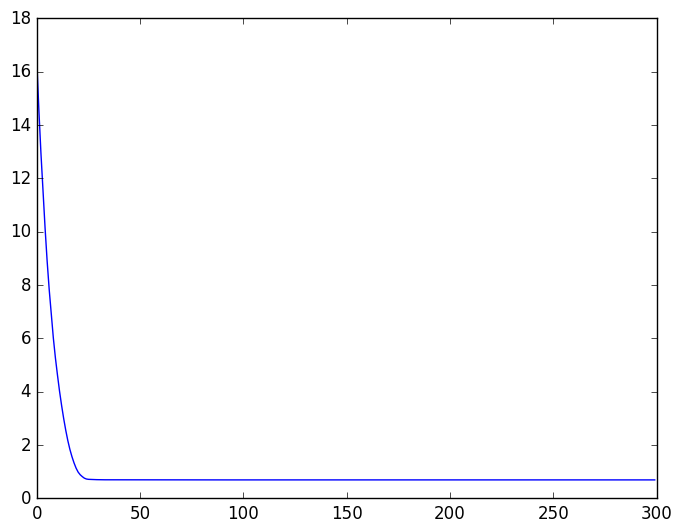

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324d98fd0>

In [15]:
# plotting the objective 
plot(objVal)

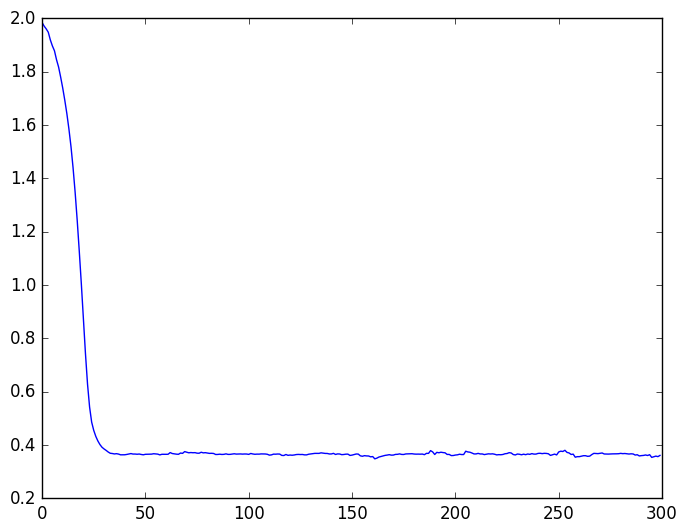

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324f648d0>

In [16]:
# plotting the loss function
plot(LF)

In [17]:
# Q1: What does y = 0 give us in terms of information?